In [1]:

# ref https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

In [55]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib
## This is for backend, gui support, but it doesnt do anything ##
matplotlib.use('TkAgg') 
from matplotlib import figure, pyplot
import math
import nltk
from nltk.corpus import stopwords
from datetime import datetime
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
from tqdm.auto import tqdm
from operator import itemgetter
import heapq
import collections
from pathlib import Path

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


In [2]:
##### Rename RiskFactors > Data > Run  <for f in *\ *; do mv "$f" "${f// /_}"; done> in bash, in Data ####
##### This changes all " " characters to "_", needed for Path######
##### See https://stackoverflow.com/a/18213120 #####


NUMBER_OF_DOCS = 100
doclist = []
names = []
pathlist = Path("Data_Small").glob('**/*.txt')
pathlist = Path("Data").glob('**/*.txt')
for path in tqdm(pathlist):
    # because path is object not string
    path_in_str = str(path)
    name = path_in_str.split("\\")[1].split(".")[0]
    names.append(name)
    #TODO SPLIT PATH TO COMPANY NAME, make Index
    file = open(path, "r") 
    # print "Output of Readlines after appending"
    text = file.readlines()
#     print(text[:10])
    doclist.append(text[0].replace(name, "<NAME>"))
if len(doclist) > NUMBER_OF_DOCS:
    doclist = doclist[:NUMBER_OF_DOCS]
    names = names[:NUMBER_OF_DOCS]

In [3]:
print('%s docs loaded'% len(names))
print()
print(names[:10], '......',  names[-10:])


100 docs loaded

['180_Degree_Capital_Corp_', '1_800_FLOWERS_COM_Inc_', '2U_Inc_', '3D_Systems_Corporation', '3M_Company', 'A10_Networks_Inc_', 'AAC_Holdings_Inc_', 'AAON_Inc_', 'AAR_Corp_', 'Abbott_Laboratories'] ...... ['Alaska_Air_Group_Inc_', 'Alaska_Communications_Systems_Group_Inc_', 'Albemarle_Corporation', 'Albireo_Pharma_Inc_', 'Alcentra_Capital_Corp_', 'Alcoa_Corporation', 'Alexander_39_s_Inc_', 'Alexander_Baldwin_Inc_', 'Alexandria_Real_Estate_Equities_Inc_', 'Alexion_Pharmaceuticals_Inc_']


In [4]:
# doclist[1]

# len(doclist[0])

In [5]:
def split_document(document):
    split_text = [word.lower() for word in document.replace(
        ";", ".").replace('<u+0095>', ".").split(".")]
#     TODO REPLACE WITH STOPWORDS??

#     vectorizer = TfidfVectorizer(stop_words='english')
    return split_text



In [6]:
def big_split(doclist):
    big_split_text_list = []
    big_split_name_list = []

    for counter, document in tqdm(enumerate(doclist)):
        name = names[counter]
        split_text =  [word.lower() for word in document.replace(
        ";", ".").replace('<u+0095>', ".").replace("  ", "").split(".")]
        big_split_name_list += [name for word in document.replace(
        ";", ".").replace('<u+0095>', ".").replace("  ", "").split(".")]
        big_split_text_list += split_text
#         if counter % 100 == 0:
#             print(f'{counter} of {len(doclist)}')
    return big_split_text_list, big_split_name_list

In [81]:
def vectorize_text(split_text_entry, longest_paragraph_len):
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
    more_stops = ['\\t\\t\\t', 
        '\\t\\t\\', '\\t\\t\\t',
        '<U+25CF>']
    stopWordsSet =  stopwords.words('english') + more_stops + punc
#     stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    vectorizer = TfidfVectorizer(stop_words=stopWordsSet,
                                 ngram_range=(1,15))
    sparseMatrix = vectorizer.fit_transform(split_text_entry)
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
    return sparseMatrix, vectorizer  

In [82]:
# split_text = split_document(doclist[0])
# sparseMatrix, vectorizer = vectorize_text(split_text)
# longest_paragraph_len = max(split_text, key=len)
# for multiple files, uncomment below
%time big_split_text_list, big_split_name_list = big_split(doclist)
longest_paragraph_len = len(max(big_split_text_list, key=len))


Wall time: 173 ms


In [83]:
%time sparseMatrix, vectorizer = vectorize_text(big_split_text_list, longest_paragraph_len)
# I dont think we can get tqdm to work here #

C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['25cf'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 24.5 s


In [84]:
big_split_name_list[:5]

['180_Degree_Capital_Corp_',
 '180_Degree_Capital_Corp_',
 '180_Degree_Capital_Corp_',
 '180_Degree_Capital_Corp_',
 '180_Degree_Capital_Corp_']

In [85]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 15), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... '\\t\\t\\t', '<U+25CF>', '.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '%'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [86]:
sparseMatrix

<79620x5052832 sparse matrix of type '<class 'numpy.float64'>'
	with 7263555 stored elements in Compressed Sparse Row format>

Wall time: 482 ms


C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


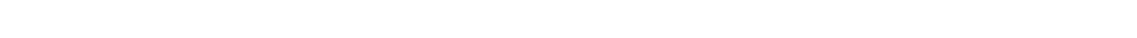

In [87]:
%matplotlib inline
# This doesnt really work when passing many documents > 100?
# https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = pyplot.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, facecolor ='black')
    ax.plot(m.col, m.row, 's', color='white', ms=3)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax



%time ax = plot_coo_matrix(sparseMatrix)
ax.figure.show()

In [88]:
# truek = PLEASE_FIND_ME
def cluster_it(sparseMatrix, vectorizer):
    truek = 25
    model = KMeans(n_clusters=truek, init='k-means++',
                   max_iter=100, n_init=1, random_state=42)
    model.fit(sparseMatrix)
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    return terms, order_centroids, model, truek

In [89]:
##THIS TAKES ~~ 1m per 100 documents
 %time terms, order_centroids, model, truek = cluster_it(sparseMatrix, vectorizer)

Wall time: 45.6 s


In [90]:
# using joblib to pickle model
model_time = datetime.now().strftime("%b%d-%I%M%p")
from sklearn.externals import joblib
joblib.dump(model, f'outputs/s2s{model_time}.pkl')
model = joblib.load(f'outputs/s2s{model_time}.pkl')

In [91]:
clusters = model.labels_.tolist()
clusters

[0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [92]:
def dataframe_it(big_split_text_list, big_split_name_list, clusters):
    first_we_dict = {'company': big_split_name_list, 'split': big_split_text_list, 'cluster': clusters}
    frame = pd.DataFrame(first_we_dict, index =clusters, columns = ['cluster', 'company', 'split'])   
    return frame

In [93]:
all_doc_df = dataframe_it(big_split_text_list, big_split_name_list, clusters)

In [94]:
all_doc_df.head()

,cluster,company,split
0,0,180_Degree_Capital_Corp_,"[1] ""item 1a"
7,7,180_Degree_Capital_Corp_,risk factors
0,0,180_Degree_Capital_Corp_,
0,0,180_Degree_Capital_Corp_,investing in our common stock involves signif...
0,0,180_Degree_Capital_Corp_,you should carefully consider the risks and u...


In [95]:
all_doc_df

,cluster,company,split
0,0,180_Degree_Capital_Corp_,"[1] ""item 1a"
7,7,180_Degree_Capital_Corp_,risk factors
0,0,180_Degree_Capital_Corp_,
0,0,180_Degree_Capital_Corp_,investing in our common stock involves signif...
0,0,180_Degree_Capital_Corp_,you should carefully consider the risks and u...
0,0,180_Degree_Capital_Corp_,these risks and uncertainties are not the onl...
0,0,180_Degree_Capital_Corp_,"unknown additional risks and uncertainties, o..."
0,0,180_Degree_Capital_Corp_,if any of these risks or uncertainties materi...
0,0,180_Degree_Capital_Corp_,"in this event, the trading price of our commo..."
0,0,180_Degree_Capital_Corp_,


In [96]:
terms[:15]

['00',
 '00 42',
 '00 although',
 '00 although revolving',
 '00 although revolving credit',
 '00 although revolving credit agreement',
 '00 although revolving credit agreement leverage',
 '00 although revolving credit agreement leverage ratio',
 '00 although revolving credit agreement leverage ratio may',
 '00 although revolving credit agreement leverage ratio may increased',
 '00 although revolving credit agreement leverage ratio may increased level',
 '00 although revolving credit agreement leverage ratio may increased level higher',
 '00 case',
 '00 case abr',
 '00 case abr loans']

In [97]:
nclosest_words_to_show = 5
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :nclosest_words_to_show]:
     print(' %s' % terms[ind])

Cluster 0:
 may
 could
 business
 product
 products
Cluster 1:
 contributions
 pension contributions include mandatory amounts required
 potential pension contributions include mandatory amounts required federal law discretionary contributions
 potential pension contributions include mandatory amounts required federal law
 potential pension contributions include mandatory amounts required federal
Cluster 2:
 changes accounting principles
 changes accounting
 accounting principles
 principles
 accounting
Cluster 3:
 table contents
 table
 contents
 µmol
 enterprises governments devote resources protecting advanced cyberattacks may include testing purchasing deploying
Cluster 4:
 53
 µmol
 enterprises governments perceived decline general level advanced
 enterprises governments devote resources protecting advanced cyberattacks may include testing purchasing deploying
 enterprises governments devote resources protecting advanced cyberattacks may include testing purchasing deploying produc

In [98]:
print('\n')
print('Prediction')
X = vectorizer.transform(['Market outlook on coffee looks promising'])
predicted = model.predict(X)
print(predicted)





Prediction
[0]


In [99]:
# HOW DO WE FIND the tag label?, 1Closest_word to cluster definitely isn't it
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :1]:
     print(' %s' % terms[ind])

Cluster 0:
 may
Cluster 1:
 contributions
Cluster 2:
 changes accounting principles
Cluster 3:
 table contents
Cluster 4:
 53
Cluster 5:
 speculation press investment
Cluster 6:
 associated international operations including
Cluster 7:
 risk factors
Cluster 8:
 22
Cluster 9:
 submitting nominations election
Cluster 10:
 event could compromise
Cluster 11:
 forego delay pursuit opportunities product candidates
Cluster 12:
 used clinical testing sale could give rise product liability claims negative
Cluster 13:
 patents product candidates throughout world would
Cluster 14:
 healthcare programs medicare
Cluster 15:
 62
Cluster 16:
 committed external source funds
Cluster 17:
 valuations similar companies
Cluster 18:
 maintain key person insurance
Cluster 19:
 goodwill intangible asset capitalized software development impairment charges adversely
Cluster 20:
 rights upon termination agreement
Cluster 21:
 achieved able
Cluster 22:
 effective transactions completed period separation occurred

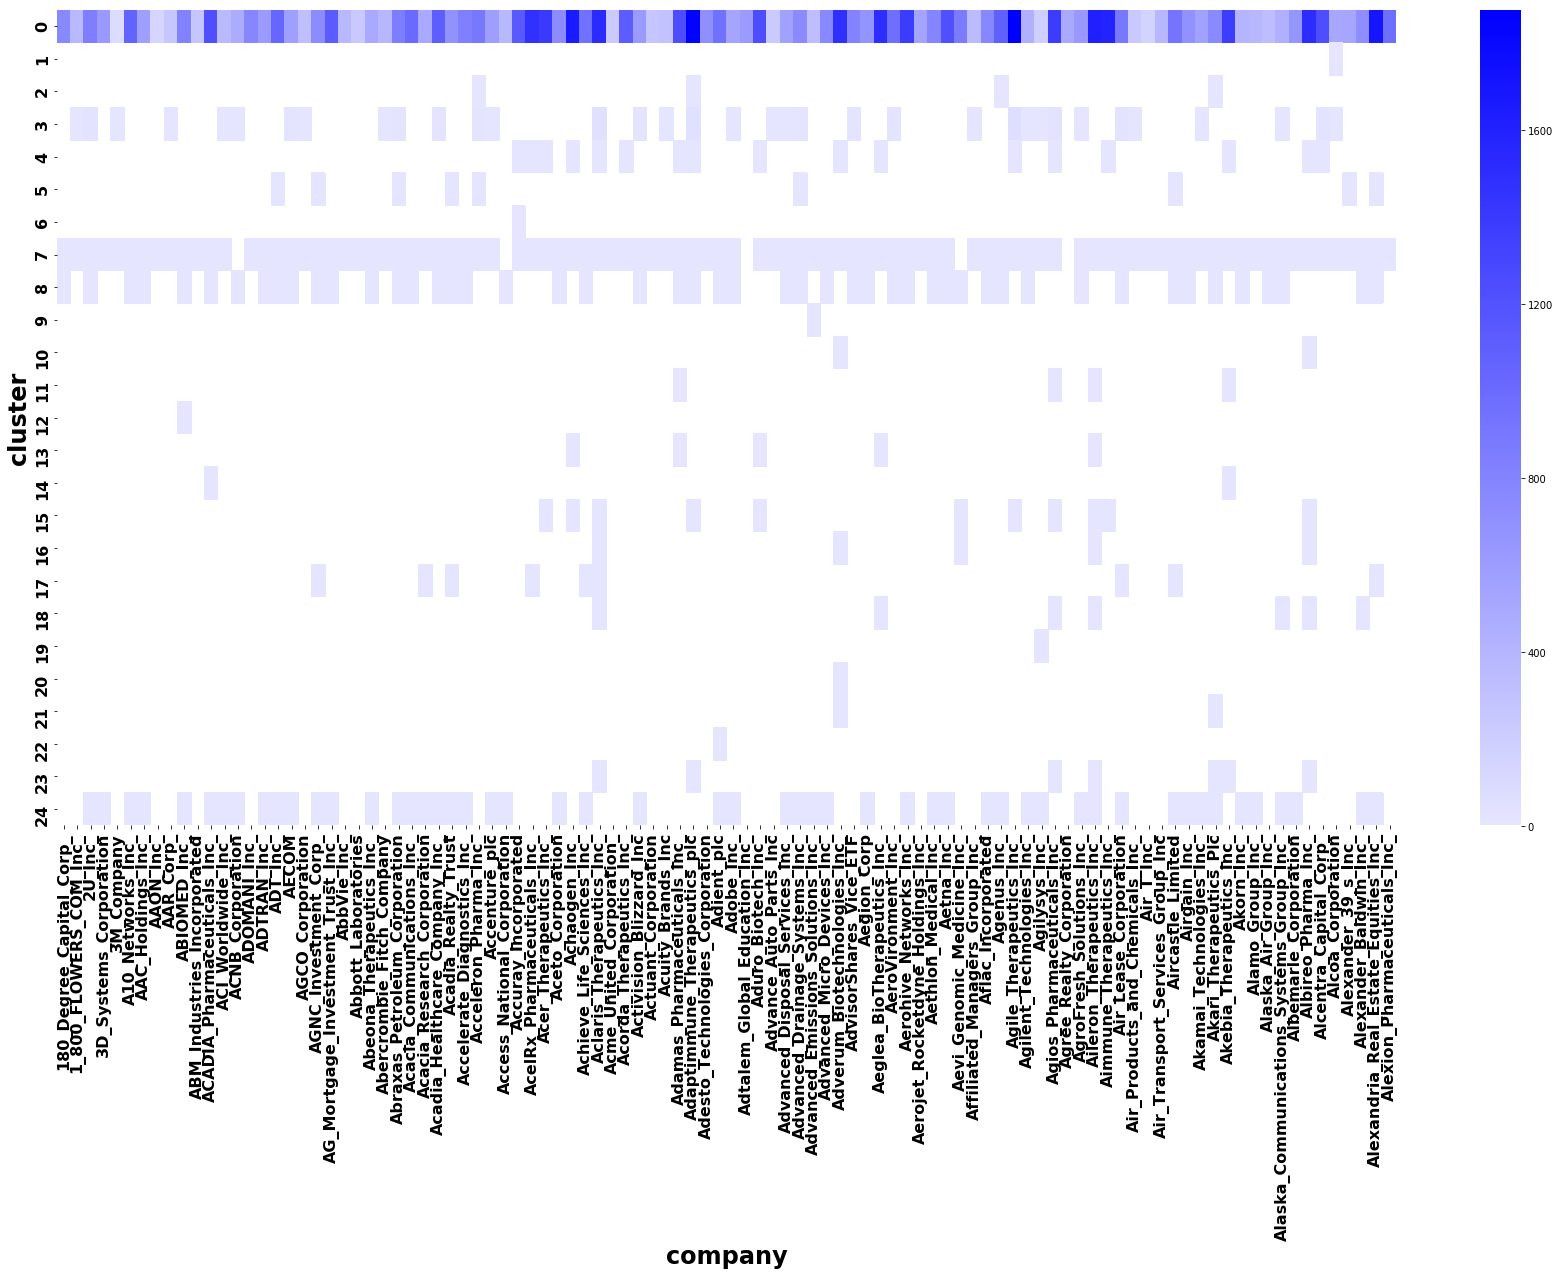

In [105]:
clusters = all_doc_df.groupby(['cluster', 'company']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
cmap = sns.light_palette('blue', as_cmap=True)

sns.heatmap(clusters.unstack(level = 'company'), ax = ax2, cmap = cmap)

ax2.set_xlabel('company', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

Automatically created module for IPython interactive environment


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

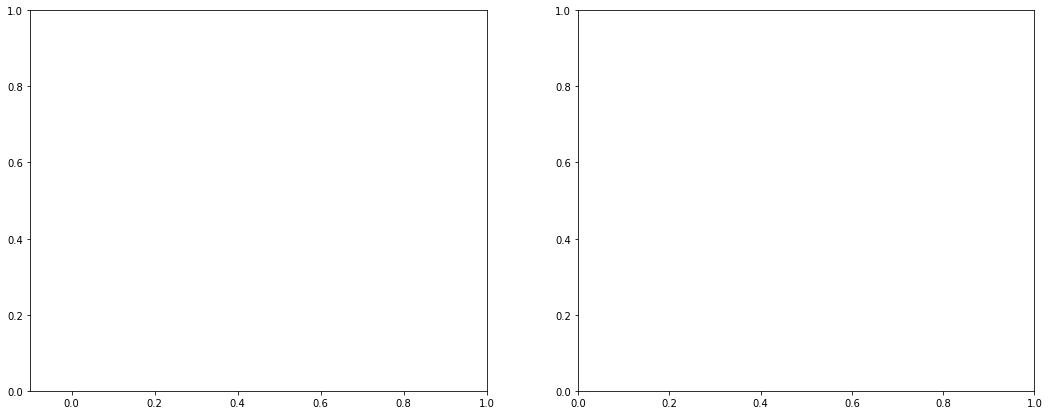

In [103]:
# SILHOUETTE VALIDATION
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = sparseMatrix[0].shape[0], sparseMatrix[1].shape[1x1607985]

range_n_clusters = range(truek)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [188]:
## TF-IDF analysis 
from nltk.corpus import stopwords
print(stopwords.words('english'))
def get_wordset(doc_text):
    words = doc_text.split(" ")
    wordSet = []
    stopWordsSet =  set(stopwords.words('english'))

#     print(stopWords)
    for w in words:
    #     wordSet.append(w)

        if w not in stopWordsSet:
            wordSet.append(w)
    return wordSet

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [189]:
def get_wordDict(wordSet):
    wordDict = dict.fromkeys(wordSet, 0) 
    for word in wordSet:
        wordDict[word]+=1

    return wordDict

In [190]:


def computeTF(document_text):
    wordset = get_wordset(document_text)
    word_dict = get_wordDict(wordset)
    tfDict = {}
    word_count = len(wordset)
    for word, count in word_dict.items():
        tfDict[word] = count/float(word_count)
    return tfDict

In [191]:
doclist[0]

'[1] "Item 1A.    Risk Factors.. Investing in our common stock involves significant risks relating to our business and investment objectives. You should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock. These risks and uncertainties are not the only ones we face. Unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business. If any of these risks or uncertainties materialize, our business, financial condition or results of operations could be materially adversely affected. In this event, the trading price of our common stock could decline, and you could lose all or part of your investment.. Risks related to our proposed change from a BDC to a registered closed-end fund.. If shareholders approve the proposal to authorize the Board of Directors to withdraw the Company\'s election to be regulated as a BDC, the withdrawal will become effective upon receipt by the SEC o

In [193]:
term_freqs = []
for i  in range(len(doclist)):
#     print(i)
    term_frequency = computeTF(doclist[i])
    term_freqs.append(term_frequency)

In [194]:
term_freqs[0]

{'[1]': 0.0001167269756040621,
 '"Item': 0.0001167269756040621,
 '1A.': 0.0001167269756040621,
 '': 0.002101085560873118,
 'Risk': 0.0001167269756040621,
 'Factors..': 0.0001167269756040621,
 'Investing': 0.0003501809268121863,
 'common': 0.007587253414264037,
 'stock': 0.00828761526788841,
 'involves': 0.0002334539512081242,
 'significant': 0.0028014474144974905,
 'risks': 0.00221781253647718,
 'relating': 0.0003501809268121863,
 'business': 0.0026847204388934284,
 'investment': 0.009805065950741217,
 'objectives.': 0.0001167269756040621,
 'You': 0.0003501809268121863,
 'carefully': 0.0002334539512081242,
 'consider': 0.0002334539512081242,
 'uncertainties': 0.0003501809268121863,
 'described': 0.0001167269756040621,
 'purchase': 0.0002334539512081242,
 'shares': 0.0029181743901015526,
 'stock.': 0.0012839967316446831,
 'These': 0.0018676316096649936,
 'ones': 0.0003501809268121863,
 'face.': 0.0001167269756040621,
 'Unknown': 0.0001167269756040621,
 'additional': 0.002684720438893428

In [195]:
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    big_wordset = []
    for doc in docList:
        big_wordset += get_wordset(doc)
    big_wordDict = get_wordDict(big_wordset)
        
    idfDict = dict.fromkeys(big_wordDict.keys(), 0)
  
    for word, val in big_wordDict.items():
        if val > 0:
            idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [196]:
idfs = computeIDF(doclist)
idfs

{'[1]': 2.0,
 '"Item': 2.0,
 '1A.': 2.0,
 '': 2.0,
 'Risk': 2.0,
 'Factors..': 2.0,
 'Investing': 2.0,
 'common': 2.0,
 'stock': 2.0,
 'involves': 2.0,
 'significant': 2.0,
 'risks': 2.0,
 'relating': 2.0,
 'business': 2.0,
 'investment': 2.0,
 'objectives.': 2.0,
 'You': 2.0,
 'carefully': 2.0,
 'consider': 2.0,
 'uncertainties': 2.0,
 'described': 2.0,
 'purchase': 2.0,
 'shares': 2.0,
 'stock.': 2.0,
 'These': 2.0,
 'ones': 2.0,
 'face.': 2.0,
 'Unknown': 2.0,
 'additional': 2.0,
 'uncertainties,': 2.0,
 'currently': 2.0,
 'immaterial,': 2.0,
 'may': 2.0,
 'also': 2.0,
 'impact': 2.0,
 'business.': 2.0,
 'If': 2.0,
 'materialize,': 2.0,
 'business,': 2.0,
 'financial': 2.0,
 'condition': 2.0,
 'results': 2.0,
 'operations': 2.0,
 'could': 2.0,
 'materially': 2.0,
 'adversely': 2.0,
 'affected.': 2.0,
 'In': 2.0,
 'event,': 2.0,
 'trading': 2.0,
 'price': 2.0,
 'decline,': 2.0,
 'lose': 2.0,
 'part': 2.0,
 'investment..': 2.0,
 'Risks': 2.0,
 'related': 2.0,
 'proposed': 2.0,
 'chang

In [197]:
def computeTFIDF(term_frequency, idfs):
    tfidf = {}
    for word, val in term_frequency.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [198]:
tfidfBow = computeTFIDF(term_frequency, idfs)


In [199]:
tfidfBow


{'[1]': 0.00018774054257016804,
 '"Item': 0.00018774054257016804,
 '1A.': 0.00018774054257016804,
 '': 0.005256735191964705,
 'Risk': 0.00037548108514033607,
 'Factors..': 0.00018774054257016804,
 '(amounts': 0.00018774054257016804,
 'millions,': 0.00018774054257016804,
 'except': 0.00018774054257016804,
 'percentages).': 0.00018774054257016804,
 'You': 0.00037548108514033607,
 'carefully': 0.00018774054257016804,
 'consider': 0.00037548108514033607,
 'following': 0.00037548108514033607,
 'risk': 0.0026283675959823524,
 'factors': 0.0013141837979911762,
 'decide': 0.0007509621702806721,
 'invest': 0.00018774054257016804,
 'Alexion': 0.0016896648831315122,
 'business': 0.01145217309678025,
 'may': 0.03961325448230545,
 'significant': 0.005819956819675209,
 'impact': 0.004505773021684032,
 'business,': 0.002065145968271848,
 'operating': 0.0028161081385525205,
 'results,': 0.00037548108514033607,
 'financial': 0.007509621702806721,
 'condition,': 0.000563221627710504,
 'cash': 0.00150192

In [200]:
# from https://stackoverflow.com/questions/4743035/obtaining-the-least-common-element-in-array
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))
least_common_values(tfidfBow, 20)

[('[1]', 0.00018774054257016804),
 ('"Item', 0.00018774054257016804),
 ('1A.', 0.00018774054257016804),
 ('Factors..', 0.00018774054257016804),
 ('(amounts', 0.00018774054257016804),
 ('millions,', 0.00018774054257016804),
 ('except', 0.00018774054257016804),
 ('percentages).', 0.00018774054257016804),
 ('carefully', 0.00018774054257016804),
 ('invest', 0.00018774054257016804),
 ('flows.', 0.00018774054257016804),
 ('ones', 0.00018774054257016804),
 ('face.', 0.00018774054257016804),
 ('presently', 0.00018774054257016804),
 ('deem', 0.00018774054257016804),
 ('immaterial', 0.00018774054257016804),
 ('Products.', 0.00018774054257016804),
 ('Currently,', 0.00018774054257016804),
 ('view', 0.00018774054257016804),
 ('Since', 0.00018774054257016804)]

In [201]:
collections.Counter(tfidfBow).most_common(20)


[('may', 0.03961325448230545),
 ('could', 0.024218529991551677),
 ('products', 0.02403078944898151),
 ('We', 0.018774054257016802),
 ('product', 0.016333427203604617),
 ('including', 0.013892800150192433),
 ('business', 0.01145217309678025),
 ('The', 0.010701210926499578),
 ('regulatory', 0.010701210926499578),
 ('•', 0.01051347038392941),
 ('clinical', 0.010325729841359241),
 ('patients', 0.009011546043368065),
 ('In', 0.009011546043368065),
 ('also', 0.008636064958227729),
 ('If', 0.00844832441565756),
 ('subject', 0.00844832441565756),
 ('financial', 0.007509621702806721),
 ('Soliris', 0.007321881160236553),
 ('us', 0.007134140617666385),
 ('Our', 0.007134140617666385)]

In [202]:
collections.Counter(term_frequency).most_common(20)



[('may', 0.019806627241152727),
 ('could', 0.012109264995775838),
 ('products', 0.012015394724490754),
 ('We', 0.009387027128508401),
 ('product', 0.008166713601802308),
 ('including', 0.006946400075096217),
 ('business', 0.005726086548390125),
 ('The', 0.005350605463249789),
 ('regulatory', 0.005350605463249789),
 ('•', 0.005256735191964705),
 ('clinical', 0.005162864920679621),
 ('patients', 0.004505773021684032),
 ('In', 0.004505773021684032),
 ('also', 0.004318032479113864),
 ('If', 0.00422416220782878),
 ('subject', 0.00422416220782878),
 ('financial', 0.0037548108514033605),
 ('Soliris', 0.0036609405801182764),
 ('us', 0.0035670703088331924),
 ('Our', 0.0035670703088331924)]

In [203]:
# Latent Dirichlet Allocation
# Ref http://brandonrose.org/clustering
# LDA is a probabilistic topic model that assumes documents
# are a mixture of topics and that each word in the document is attributable to the document's topics.
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

input_texts = doclist

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
from gensim import corpora, models, similarities 

#remove proper names0
%time preprocess = [strip_proppers(doc) for doc in input_texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
# print(texts)
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)
# print(dictionary)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.1)  
# THIS FILTERS EVERYTHING OUT
print(dictionary)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
# print(corpus)
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 13 s
Wall time: 21.7 s
Wall time: 1.89 s
Dictionary(6731 unique tokens: ['30-day', 'adverse..', 'adviser..', 'agnost', 'alongsid']...)
Wall time: 11.2 s


In [236]:
topics_matrix = lda.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['end-custom', 'vadadustat', 'elobixibat', 'contracept', 'luspatercept', 'sotatercept', 'membership', 'adhes', 'alarm', 'pruritus', 'resubmiss', 'ivosidenib', 'subscrib', 'dual', 'acid']

['zero-emiss', 'drivetrain', 'hybrid', 'agricultur', 'merchandis', 'landfil', 'peanut', 'gene', 'food', 'allergi', 'redevelop', 'batteri', 'inhal', 'shop', 'farm']

['aircraft', 'airlin', 'lesse', 'student', 'drill', 'game', 'yen', 'automot', 'accredit', 'fractur', 'dollar-denomin', 'entertain', 'flight', 'pipe', 'aviat']

['student', 'plazomicin', 'pegzilarginas', 'biosimilar', 'prepay', 'assay', 'pimavanserin', 'k', 'tumor', 'securit', 'graduat', 'subscript', 'gene', 'resist', 'peptid']

['\\t\\t\\t', '\\t\\t', 'aircraft', 'cytisin', '\\t\\t\\tthe', 'lesse', 'antibodi', 'airlin', 'aluminum', 'pain', 'inhibitor', 'vaccin', 'tablet', '\\t\\t\\tour', 'resubmiss']



In [205]:
# https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing
lsi = models.lsimodel.LsiModel(corpus, num_topics=5, id2word=dictionary, chunksize=1000)
topics_matrix = lsi.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)
topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['\\t\\t\\t', '\\t\\t', 'aircraft', 'lesse', '\\t\\t\\tthe', 'airlin', 'inhibitor', 'pain', '\\t\\t\\tour', 'fleet', 'remarket', 'aviat', 'tablet', 'wart', 'repossess']

['aircraft', 'lesse', '\\t\\t\\t', 'airlin', '\\t\\t', 'aviat', 'repossess', 'fleet', 'remarket', '\\t\\t\\tthe', 're-leas', 'passeng', 'aircraft..', 'nois', 'lessor']

['cytisin', 'cytisine..', 'student', 'counterfeit', 'smoke', 'anagyroid', 'tree', 'profitable..', 'graduat', 'riski', 'sunshin', 'drought', 'authent', 'toxicolog', 'naturally-occur']

['student', 'graduat', 'accredit', 'school', 'colleg', 'faculti', 'tuition', 'aid', 'cytisin', 'postsecondari', 'accreditor', 'admiss', 'nonprofit', 'misrepresent', 'internet']

['zero-emiss', 'drivetrain', 'hybrid', 'batteri', 'buse', 'fleet', 'truck', 'lithium-ion', 'lock-up', 'petroleum-bas', 'motor', 'pack', 'kit', 'automot', 'diesel']



In [206]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X[0])
print()
print(dist)

TypeError: 'int' object is not subscriptable

In [50]:
# SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta

# Topic 0: investment, property, distribution, interest, agreement Shareholder’s interest risk 
# Topic 1: regulation, change, law, financial, operation, tax, accounting *Regulation changes(accounting)
# Topic 2: gas, price, oil, natural, operation, production Input prices risks 
# Topic 3: stock, price, share, market, future, dividend, security, stakeholder ** Stakeholder’s profit
# Topic 4: cost, regulation, environmental, law, operation, liability *Regulation changes(environment) 
# Topic 5: control, financial, internal, loss, reporting, history Financial condition risks 
# Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit *Potential/Ongoing Lawsuits
# Topic 7: competitive, industry, competition, highly, market Competition risks 
# Topic 8: cost, operation, labor, operating, employee, increase, acquisition **Labor cost 
# Topic 9: product, candidate, development, approval, clinical, regulatory New product introduction risks 
# Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible **Accounting,  +Restructuring risks 
# Topic 11: interest, director, officer, trust, combination, share, conflict **Management
# Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products 
# Topic 13: loan, real, estate, investment, property, market, loss, portfolio **Investment 
# Topic 14: personnel, key, retain, attract, management, employee Human resource risks 
# Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile Volatile stock price risks 
# Topic 16: acquisition, growth, future, operation, additional, capital, strategy Merger & Acquisition risks 
# Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks, +Industry is cyclical 
# Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations, +Infrastructure risks 
# Topic 19: cost, contract, operation, plan, increase, pension, delay **Postpone 
# Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers, +Suppliers risks +Downstream risks 
# Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm, license Intellectual property risks, +Licensing related risks 
# Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results, + Competition risks 
# Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw *Potential/Ongoing Lawsuits 
# Topic 24: regulation, government, change, revenue, contract, law, service *Regulation changes 
# Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade **Credit risks 
# Topic 26: debt, indebtedness, cash, obligation, financial, credit, covenant Funding risks 
# Topic 27: operation, international, foreign, currency, rate, fluctuation International risks 
# Topic 28: loss, insurance, financial, loan, reserve, operation, cover **Insurance 
# Topic 29: operation, natural, facility, disaster, event, terrorist, weather Catastrophes

SyntaxError: EOL while scanning string literal (<ipython-input-50-6ea71ef07562>, line 2)